In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm

In [3]:
import os
from google.colab import files

In [4]:
from pathlib import Path
from zipfile import ZipFile

In [5]:
dataset_zip_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images.zip")
dataset_path = Path("/content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images")
if not dataset_zip_path.exists():
  files.upload()
  os.mkdir('/root/.kaggle')
  !cp kaggle.json /root/.kaggle/''
  !kaggle datasets download -d kimduhan/fashion-pattern-images
else:
  print("kimduhan/fashion-pattern-images already downloaded")

if not dataset_path.is_dir():
  with ZipFile(dataset_zip_path,"r") as f:
    f.extractall(dataset_path)
else:
  print("Dataset is extracted")

kimduhan/fashion-pattern-images already downloaded
Dataset is extracted


In [6]:
for dirpath,dirname,filenames in os.walk(dataset_path):
  print(f"Dir {dirpath} has {len(dirname)} dirs & {len(filenames)} files")

Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images has 1 dirs & 0 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images has 19 dirs & 0 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/argyle has 0 dirs & 552 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/camouflage has 0 dirs & 569 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/checked has 0 dirs & 563 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/dot has 0 dirs & 611 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/floral has 0 dirs & 581 files
Dir /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images/geometric has 0 dirs & 554 files
Dir /conten

1000 750
camouflage


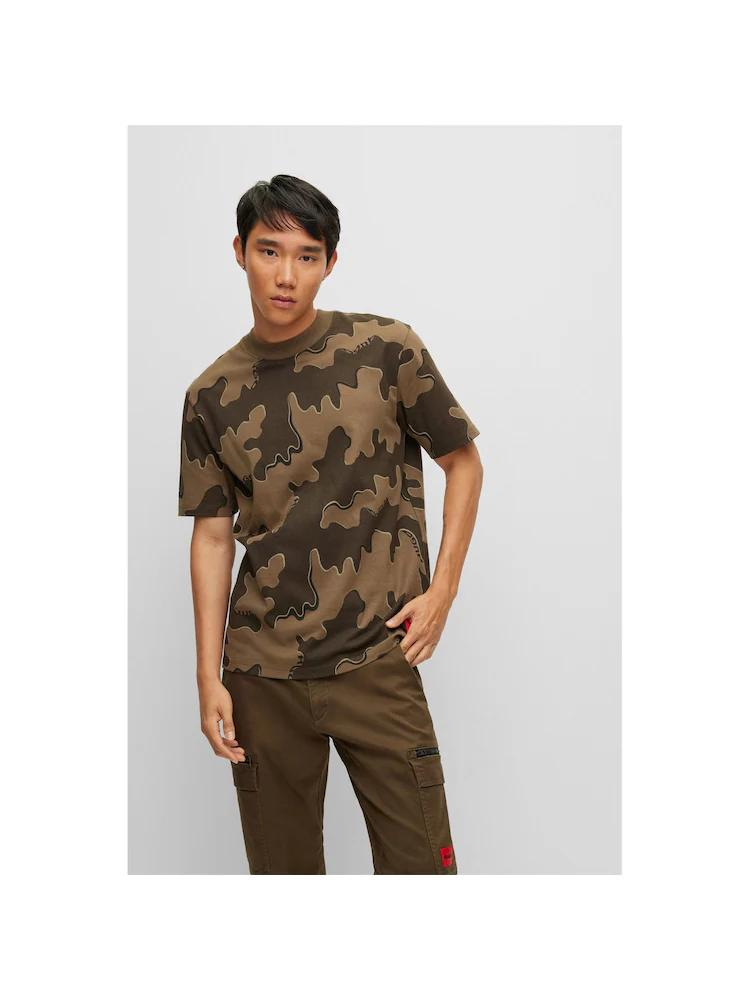

In [7]:
import random
from PIL import Image

image_list = list(dataset_path.glob("*/*/*.jpg"))

random_img = random.choice(image_list)

random_img_class = random_img.parent.stem

img = Image.open(random_img)
print(img.height,img.width)
print(random_img_class)
img

(1000, 750, 3)


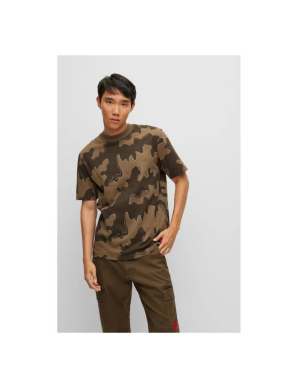

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_numpy = np.asarray(img)
plt.imshow(img_numpy)
print(img_numpy.shape)
plt.axis(False)
plt.show()

In [9]:
dataset_img_path = dataset_path/"fashion-pattern-images"

In [10]:
from torch.utils.data import DataLoader,random_split
from torchvision import datasets,transforms
import torchvision.models as models
import timm
from tqdm import tqdm

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.TrivialAugmentWide(31),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)

In [12]:
img_dataset = datasets.ImageFolder(dataset_img_path,transform=transform)

In [13]:
img_dataset

Dataset ImageFolder
    Number of datapoints: 10898
    Root location: /content/drive/MyDrive/Colab Notebooks/datasets/fashion-pattern-images/fashion-pattern-images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
len(img_dataset.classes)

19

In [15]:
train_dataset,test_dataset = random_split(img_dataset,[0.8,0.2])

In [16]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=128,
                              shuffle= True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=128,
                             shuffle=True)

(-0.5, 223.5, 223.5, -0.5)

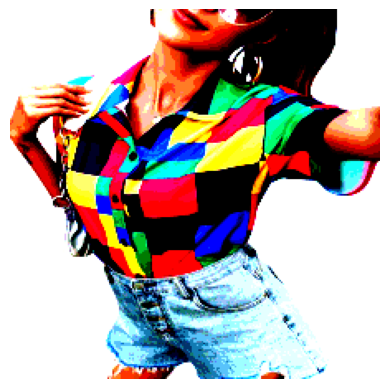

In [17]:
img,label = train_dataset[9]

plt.imshow(img.permute(1,2,0))
plt.axis(False)

In [18]:
import torch.nn as nn
import torch
from sklearn.metrics import confusion_matrix,classification_report

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [20]:
class PatternModel(nn.Module):
  def __init__(self,input=3,hidden_layers=5,output=19):
    super().__init__()

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Sigmoid(),

        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Sigmoid(),
        nn.MaxPool2d(2)
    )

    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Sigmoid(),

        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Sigmoid(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_layers*16*16,
                  out_features=output)
    )

  def forward(self,X):
    X = self.conv_layer1(X)
    X = self.conv_layer2(X)
    X = self.classifier(X)

    return X

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [22]:
test = PatternModel()

In [23]:
#test(img.unsqueeze(dim=0))

In [24]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn
):

  train_loss, train_acc = 0,0
  for batch,(X,Y) in enumerate(dataloader):
    X = X.to(device)
    Y = Y.to(device)
    model.train()
    pred = model(X)
    loss = loss_fn(pred,Y)
    train_loss+=loss.item()
    acc = accuracy_fn(Y,pred.argmax(dim=1))
    train_acc+=acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss,train_acc

In [25]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn
):

  test_loss, test_acc = 0,0
  for batch,(X,Y) in enumerate(dataloader):
    with torch.inference_mode():
      X = X.to(device)
      Y = Y.to(device)
      model.eval()
      pred = model(X)
      loss = loss_fn(pred,Y)
      test_loss+=loss.item()
      acc = accuracy_fn(Y,pred.argmax(dim=1))
      test_acc+=acc

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss,test_acc

In [26]:
dum = models.resnet50(pretrained=True)
dum.fc = nn.Linear(dum.fc.in_features, 19)
dum = dum.to(device)
next(dum.parameters()).device

dum1 = timm.create_model("rexnet_150",pretrained=True, num_classes=19)
dum1 = dum1.to(device)
next(dum1.parameters()).device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in a

device(type='cpu')

In [ ]:
#model = PatternModel().to(device)
'''model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 19)'''
model = timm.create_model("rexnet_150",pretrained=True,num_classes=19)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.003)

epochs = 10
train_loss_list,test_loss_list = [],[]
train_acc_list,test_acc_list = [],[]

for epoch in tqdm(range(epochs)):
  loss,acc = train_step(model,
                        train_dataloader,
                        loss_fn,
                        optimizer,
                        accuracy_fn)
  print(f"Train loss {loss:.5f} | Train Acc {acc:.2f}%")
  train_loss_list.append(loss)
  train_acc_list.append(acc)

  loss,acc = test_step(model,
                        test_dataloader,
                        loss_fn,
                        accuracy_fn)
  print(f"Test loss {loss:.5f} | Test Acc {acc:.2f}%")
  test_loss_list.append(loss)
  test_acc_list.append(acc)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_loss_list

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)),train_loss_list,c="b")
plt.plot(range(len(test_loss_list)),test_loss_list,c="r")
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)),train_acc_list,c="b")
plt.plot(range(len(test_acc_list)),test_acc_list,c="r")
plt.title("Acc")